# Reinforcement Learning - HW 2

## by Clarice Mottet

0. **[Part 0: Set Up](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

1. **[Part 1: Approximate Policy Evaluation](#part1)**
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation and plot example
  - LSTD algorithm creation and plot example
  - Plot Lazy Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Plot Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare difference betweeh Lazy and Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

2. **[Part 2: Approximate Policy Iteration](#part2)**
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method
  - Plot value function after 10 and 100 iterations and compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret

## <a id='part0'>Part 0: Set Up</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

- Set up libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


- Initialize global variables

In [185]:
N_MAX = 100
GAMMA = 0.9

Q_LOW = 0.51
Q_HIGH = 0.6

COST_LOW = 0.0
COST_HIGH = 0.01

ARRIVAL_RATE = 0.5

ACTION_LIST = [0, 1] #action_ind (low = 0, high = 1)

MAX_ITER_LIST = [10e4, 10e5, 10e6, 10e7]
MAX_ITER_LIST_STR = ['10e4', '10e5', '10e6', '10e7']

#step size parameters for alpha_t = (A/t+B) in TD(0)
A_step = 10e5
B_step = 10e5


- Create functions to be used throughout notebook base on problem set up
    - reward functions
    - transition functions
    - evaluation functions
    - simulation functions
    - feature maps
    - policy functions from hw1
    - value iteration and policy iteration from hw1

In [4]:
#reward functions

def action_cost(action_ind):
    if action_ind == 0:
        return COST_LOW
    else:
        return COST_HIGH

def reward_calc(x, action_ind):
    return -((x/N_MAX)**2) - action_cost(action_ind)

def reward_under_policy(pi):
    r_pi = np.zeros(N_MAX)
    for x in range(0, N_MAX):
        # action_ind = None
        for a in ACTION_LIST:
            r_pi[x] += reward_calc(x, a)*pi[x,a]
    return r_pi


In [5]:
#transitions functions

def reduction_rate(action_ind):
    if action_ind == 0:
        return Q_LOW
    else:
        return Q_HIGH
    
def transition_framework():
    #conditional matrix P(x, x_prime, a)
    P = np.zeros((N_MAX,N_MAX,2))
    for x in range(0,N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                P[x, 0, a] = (1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                P[x, 1, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
            elif x == (N_MAX-1):
                P[x, N_MAX-2, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                P[x, N_MAX-1, a] = (1-reduction_rate(a)) + (reduction_rate(a))*(ARRIVAL_RATE)
            else:
                #(decrement, increment)
                for x_prime in [x-1, x, x+1]:
                    if x_prime == (x-1):
                        #(1,0)
                        P[x, x_prime, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                    if x_prime == x:
                        #(0,0) + (1,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                    if x_prime == (x+1):
                        #(0,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(ARRIVAL_RATE)
    return P

def transition_under_policy(pi):
    P = transition_framework()

    #create transition matrix based on policy P(x, x_prime)
    P_pi = np.zeros((N_MAX,N_MAX))
    for x in range(N_MAX):
        for x_prime in [x-1, x, x+1]:
            if (x_prime < N_MAX) and (x_prime >= 0):
                for a in ACTION_LIST:
                    P_pi[x,x_prime] += P[x,x_prime,a]*pi[x,a]
    return P_pi


In [6]:
#evaluation functions

def value_under_policy(pi):
    P = transition_framework()
    r = reward_under_policy(pi)

    X = np.size(P,1)
    V_pi = np.zeros((X))

    P_pi = transition_under_policy(pi)
    V_pi = np.linalg.inv(np.eye(X) - GAMMA*P_pi).dot(r)
    return V_pi


In [7]:
#simulation functions

def next_state(state_val, action_ind):
    increment_t = random.choices([0, 1], weights=[1-ARRIVAL_RATE, ARRIVAL_RATE])[0]
    decrement_t = random.choices([0, 1], weights=[1-reduction_rate(action_ind), reduction_rate(action_ind)])[0]
    net_t = increment_t - decrement_t
    return min(N_MAX-1, max(state_val + net_t, 0))

def plot_results(data, x_title, y_title, title, color):
    plt.figure(figsize=(5, 3))
    plt.plot(data, linestyle = 'dotted', color = color)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()


In [138]:
#feature maps

def fine_feature_map(x):
    phi = np.zeros(N_MAX)
    phi[x] = 1
    return phi

def coarse_feature_map(x):
    phi = np.zeros(int(N_MAX/5))
    for i in range(int(N_MAX/5)):
        if x in range(int(5*i),int(5*i)+5):
            phi[i] = 1
    return phi

def piecewise_feature_map(x):
    phi = np.zeros((int((N_MAX/5))*2))

    phi_coarse = coarse_feature_map(x)
    for i in range(int(N_MAX/5)):
        phi[i] = phi_coarse[i]
        if phi[i] == 1:
            phi[i+int(N_MAX/5)] = phi[i]*((x - 5*i)/5)
    return phi


In [9]:
#policies

def policy_lazy():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        pi[x, 0] = 1 #action_ind (low = 0, high = 1)
        pi[x, 1] = 0
    return pi

def policy_aggr():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        if x < 50:
            pi[x, 0] = 1 #action_ind (low = 0, high = 1)
            pi[x, 1] = 0
        else:
            pi[x, 0] = 0 
            pi[x, 1] = 1 #action_ind (low = 0, high = 1)
    return pi


In [181]:
#HW1 functions

def value_iteration(max_iter):
    #initialize frameworks 
    P = transition_framework()
    r = np.zeros((N_MAX, 2))
    for x in range(N_MAX):
        for a in ACTION_LIST:
            r[x,a] = reward_calc(x,a)

    #initialize value function
    V = np.zeros((N_MAX, 1))

    #value iteration
    for k in range(max_iter):
        V_star = -np.inf
        for a in range(2):
            V_star = np.maximum(V_star, r[:, a].reshape([-1, 1]) + GAMMA* P[:, :, a].dot(V))
        V = V_star
    
    return V.flatten()

def policy_iteration(max_iter):

    #initialize frameworks
    P = transition_framework()
    pi_star = policy_aggr()

    #policy iteration
    for k in range(max_iter):

        V_new = value_under_policy(pi_star)

        V_max = np.zeros((N_MAX,2))
        for x in range(N_MAX):
            for a in ACTION_LIST:
                V_max[x,a] = reward_calc(x,a) + GAMMA*P[x, :, a].dot(V_new)

        pi_star = np.eye(V_max.shape[1])[np.argmax(V_max, axis=1)]

    return value_under_policy(pi_star), pi_star


## <a id='part1'>Part 1: Approximate Policy Evaluation</a>
- **Objective**: Study the performance of simple policies using TD(0) and LSTD
- **Tasks:**
  - TD(0) algorithm creation and plot example
  - LSTD algorithm creation and plot example
  - Plot Lazy Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Plot Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare difference betweeh Lazy and Aggressive Policy value function results by
      - max_iter ($10^4, 10^5, 10^6, 10^7$)
      - method (TD(0), LSTD(0): [fine, coarse, piecewise])
  - Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

- TD(0) algorithm creation and plot example

In [131]:
#TD(O) algorithm

def td_zero(x_init, pi, max_iter):

    #initialize
    V_t = value_under_policy(pi)
    V_tpo = V_t

    x_t = x_init
    a_t = np.argmax(pi[x_t])
    x_tpo = next_state(x_t, a_t)
    track_x_t = []
    track_x_t.append(x_t)

    #run iterations
    for t in range(int(max_iter)):
        alpha_t = (A_step/(t+B_step))
        delta_t = reward_calc(x_t, a_t) + GAMMA*V_t[x_tpo] - V_t[x_t]

        V_tpo[x_t] = V_t[x_t] + alpha_t*delta_t

        V_t = V_tpo
        x_t = x_tpo
        a_t = np.argmax(pi[x_t])
        x_tpo = next_state(x_t, a_t)
        track_x_t.append(x_t)

    return V_t, track_x_t


min state: 0


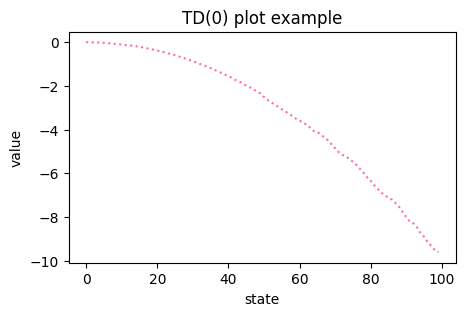

In [132]:
#TD zero plot example

pi_init = policy_aggr()

V_td_zero, track_x_t = td_zero(99, pi_init, 10e4)
print(f'min state: {min(track_x_t)}')

plot_results(V_td_zero, 'state', 'value', 'TD(0) plot example', 'hotpink')

- LSTD algorithm creation and plot example

In [133]:
# LSTD(0) algorithm

def lstd_zero(x_init, pi, feature_map, max_iter):

    #initialize
    x_t = x_init
    a_t = np.argmax(pi[x_t])
    r_t = reward_calc(x_t, a_t)
    x_tpo = next_state(x_t, a_t)
    track_x_t = []
    track_x_t.append(x_t)

    A_t = np.zeros((feature_map(x_t).shape[0], feature_map(x_t).shape[0]))
    b_t = np.zeros((feature_map(x_t).shape[0]))

    #run LSTD(0)
    for t in range(int(max_iter)):
        A_t += np.outer(feature_map(x_t), (feature_map(x_t) - GAMMA*feature_map(x_tpo)).T)
        b_t += r_t*feature_map(x_t)

        x_t = x_tpo
        a_t = np.argmax(pi[x_t])
        r_t = reward_calc(x_t, a_t)
        x_tpo = next_state(x_t, a_t)
        track_x_t.append(x_t)

    #create theta vector
    theta = np.dot(np.linalg.pinv(A_t), b_t) #(1/int(max_iter))*

    #apply theta vector
    V = np.zeros((N_MAX))
    for x in range(N_MAX):
        V[x] = np.dot(theta.T, feature_map(x))

    return V, track_x_t


min state: 0


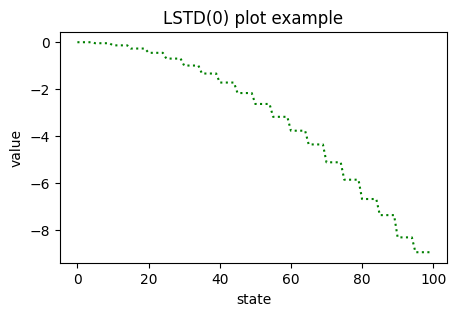

In [140]:
#lstd zero plot example

pi_init = policy_lazy()

V_lstd_zero, track_x_t = lstd_zero(99, pi_init, coarse_feature_map, 10e5)

print(f'min state: {min(track_x_t)}')
plot_results(V_lstd_zero, 'state', 'value', 'LSTD(0) plot example', 'green')

- Track Runs

In [182]:
combs = [(policy_lazy(), fine_feature_map, 'Lazy','Fine'), (policy_aggr(), fine_feature_map, 'Aggr','Fine'),
         (policy_lazy(), coarse_feature_map, 'Lazy','Coarse'), (policy_aggr(), coarse_feature_map, 'Aggr','Coarse'),
         (policy_lazy(), piecewise_feature_map, 'Lazy','PW'), (policy_aggr(), piecewise_feature_map, 'Aggr','PW')]

dict_track = {}
for val in MAX_ITER_LIST:
    dict_track[val] = {}

dict_track[10] = {}
dict_track[100] = {}
dict_policy = {}
dict_policy[10] = {}
dict_policy[100] = {}


- Plot Lazy Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])

0
1
2


KeyboardInterrupt: 

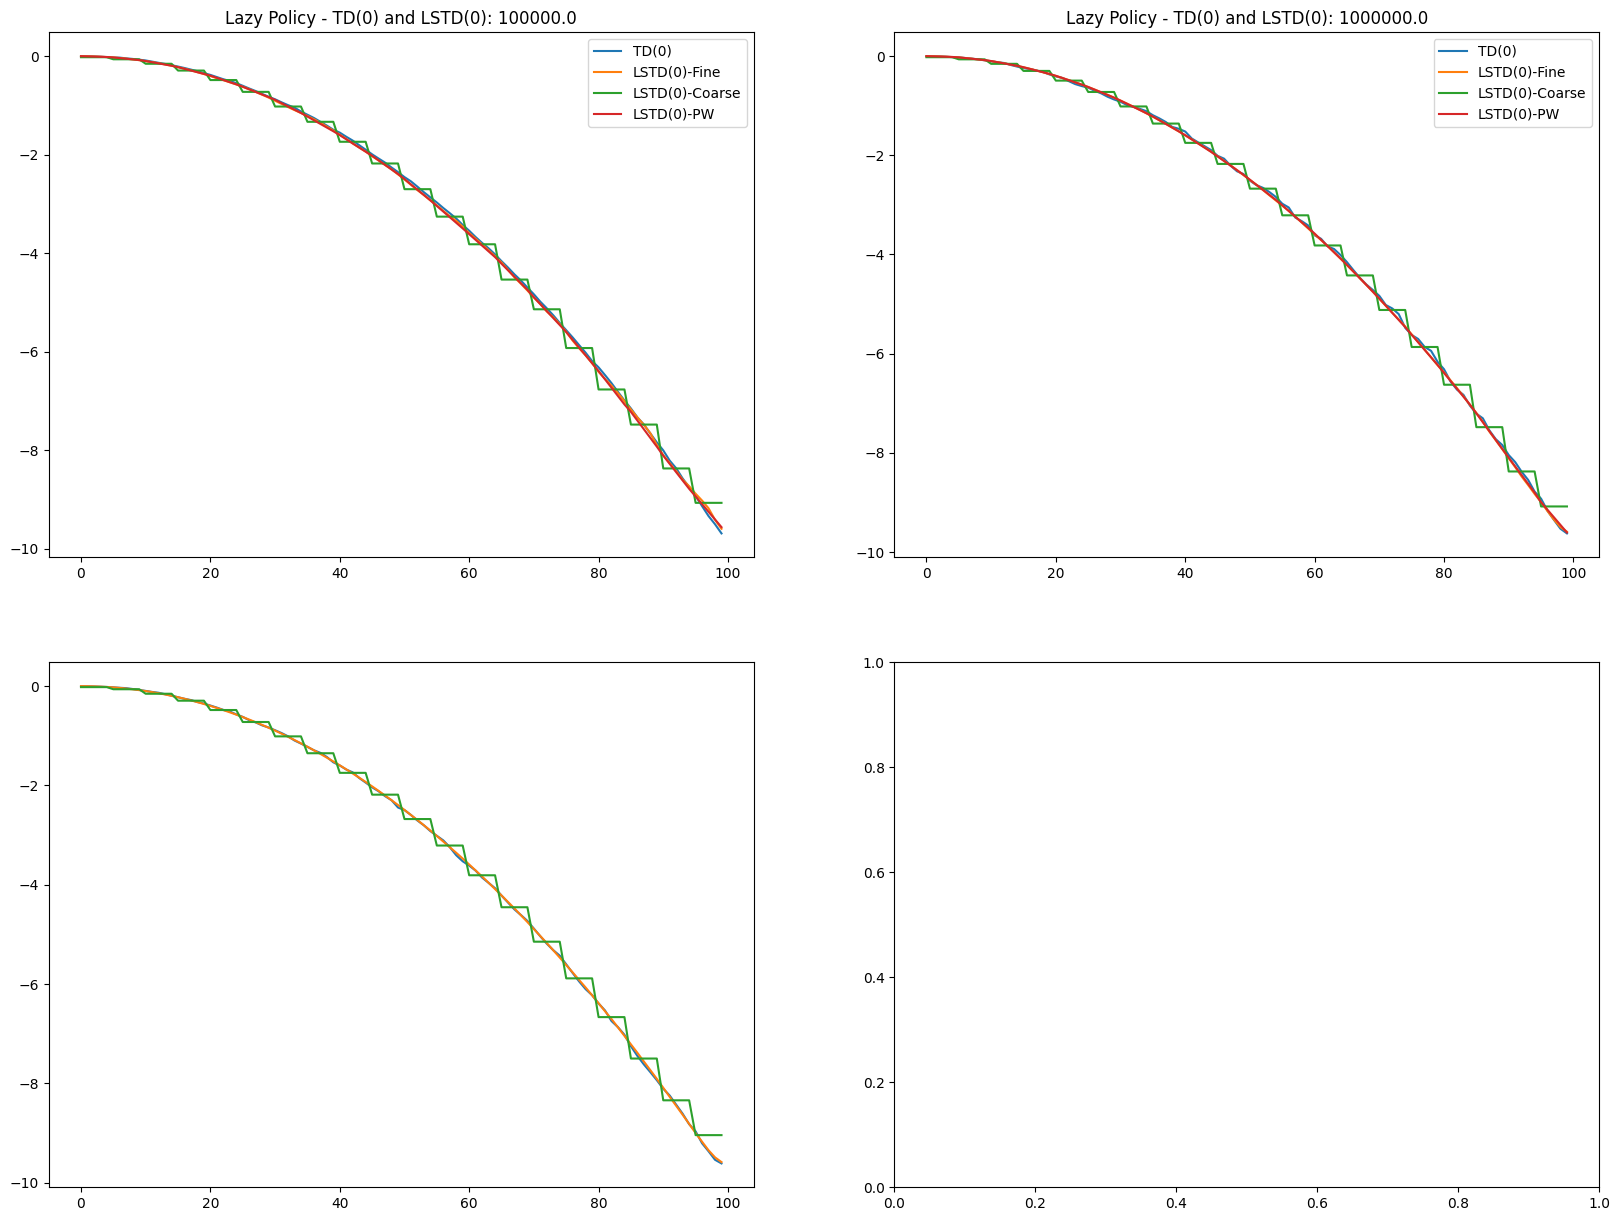

In [184]:
#Lazy Policy

policy = 'Lazy'
pi = policy_lazy()

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    print(i)

    V_, track_x_t = td_zero(99, pi, MAX_ITER_LIST[i])
    name = ('TD(0)', policy)
    dict_track[MAX_ITER_LIST[i]][name] = V_
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_, track_x_t = lstd_zero(99, pi, comb[1], MAX_ITER_LIST[i])
            name = ('LSTD(0)', policy, comb[3])
            dict_track[MAX_ITER_LIST[i]][name] = V_
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'{policy} Policy - TD(0) and LSTD(0): {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()


- Plot Aggressive Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])

In [ ]:
#Aggressive Policy

policy = 'Aggr'
pi = policy_aggr()

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    print(i)

    V_, track_x_t = td_zero(99, pi, MAX_ITER_LIST[i])
    name = ('TD(0)', policy)
    dict_track[MAX_ITER_LIST[i]][name] = V_
    ax.plot(V_, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_, track_x_t = lstd_zero(99, pi, comb[1], MAX_ITER_LIST[i])
            name = ('LSTD(0)', policy, comb[3])
            dict_track[MAX_ITER_LIST[i]][name] = V_
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'{policy} Policy - TD(0) and LSTD(0): {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

- Compare difference betweeh Lazy and Aggressive Policy value function results by
    - max_iter ($10^4, 10^5, 10^6, 10^7$)
    - method (TD(0), LSTD(0): [fine, coarse, piecewise])


In [ ]:
#Compare Lazy and Aggr value functions by method

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    name = ('TD(0)', policy)
    V_diff = dict_track[MAX_ITER_LIST[i]][('TD(0)', 'Lazy')] - dict_track[MAX_ITER_LIST[i]][('TD(0)', 'Aggr')]
    ax.plot(V_diff, label = 'TD(0)')

    for comb in combs:
        if comb[2] == 'Lazy':
            V_diff = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', 'Lazy', comb[3])] - dict_track[MAX_ITER_LIST[i]][('LSTD(0)', 'Aggr', comb[3])]
            ax.plot(V_diff, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'Lazy and Aggr Difference by Method: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

- Compare to results from HW1 by incorporating the below into the plot
    - Value function under lazy policy
    - Value function under aggressive policy
    - Value function from policy iteration[100]

In [ ]:
#Lazy Comparison to HW1

policy = 'Lazy'
pi = policy_lazy()
V_pi = value_under_policy(pi)
V_star, pi_star_policy = policy_iteration(100)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    ax.plot(V_pi, label = 'V_pi')
    ax.plot(V_star, label = 'PI[100]')

    V_ = dict_track[MAX_ITER_LIST[i]][('TD(0)', policy)]
    ax.plot(V_diff, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_ = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', policy, comb[3])]
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'HW1 Compare, {policy} Policy: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

In [ ]:
#Aggressive Comparison to HW1

policy = 'Aggr'
pi = policy_aggr()
V_pi = value_under_policy(pi)
V_star, pi_star_policy = policy_iteration(100)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):

    ax.plot(V_pi, label = 'V_pi')
    ax.plot(V_star, label = 'PI[100]')

    V_ = dict_track[MAX_ITER_LIST[i]][('TD(0)', policy)]
    ax.plot(V_diff, label = 'TD(0)')

    for comb in combs:
        if comb[2] == policy:
            V_ = dict_track[MAX_ITER_LIST[i]][('LSTD(0)', policy, comb[3])]
            ax.plot(V_, label = f'LSTD(0)-{comb[3]}')

    ax.title.set_text(f'HW1 Compare, {policy} Policy: {MAX_ITER_LIST_STR[i]}')
    ax.legend()

plt.show()

## <a id='part2'>Part 2: Approximate Policy Iteration</a>
- **Objective**: implement an approximate policy iteration method
- **Tasks:**
  - Create approximate policy iteration method and plot example
  - Plot value function after 10 and 100 iterations
  - Compare to value function from Part1
  - Compare the value function to the optimal value function from HW1
  - Plot the service rates assigned by the final policy, interpret

In [128]:
#policy evaluation and policy improvement

def policy_evaluation(pi, feature_map):
    V_k, track_x_t = lstd_zero(99, pi, feature_map, 10e5)
    return V_k

def policy_improvement(V):

    #create Q function estimate
    Q = np.zeros((N_MAX, len(ACTION_LIST)))
    
    for x in range(N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*V[x] + \
                            GAMMA*ARRIVAL_RATE*(reduction_rate(a)*V[x] + (1-reduction_rate(a)*V[x+1]))
            elif x == 99:
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*(reduction_rate(a)*V[x-1] + (1-reduction_rate(a))*V[x]) + \
                            GAMMA*ARRIVAL_RATE*V[x]
            else:
                Q[x,a] = reward_calc(x,a) + \
                        GAMMA*(1-ARRIVAL_RATE)*(reduction_rate(a)*V[x-1] + (1-reduction_rate(a))*V[x]) + \
                            GAMMA*ARRIVAL_RATE*(reduction_rate(a)*V[x] + (1-reduction_rate(a)*V[x+1]))

    #new policy is the greedy policy wrt Q
    pi_k = np.zeros((N_MAX, len(ACTION_LIST)))
    pi_k = np.argmax(Q, axis=1)

    return pi_k

def approx_policy_iteration(pi_init, feature_map, max_iter):

    #initialize pi
    pi_k = pi_init

    #policy iteration
    for k in range(max_iter):

        V_k = policy_evaluation(pi_k, feature_map)
        pi_k = policy_improvement(V_k)

    return V_k, pi_k


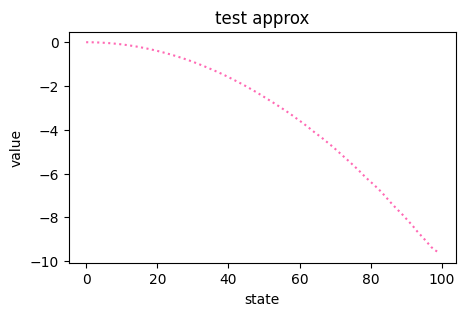

In [129]:
V_k, pi_k = approx_policy_iteration(policy_lazy(), fine_feature_map, 5)

plot_results(V_k, 'state','value','ApproxPI plot example', 'hotpink')

- Plot value function after 10 and 100 iterations

In [ ]:
#Approximate PI

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        for comb in combs:
            V_k, pi_k = approx_policy_iteration(combs[0], combs[1], 10)
            ax.plot(V_k, label = f'{comb[2]-comb[3]}')
            name = ('API', comb[2], comb[3])
            dict_track[10][name] = V_k
            dict_policy[10][name] = pi_k
        ax.title.set_text(f'Approx PI: 10 Iterations')
        ax.legend()
    else:
        for comb in combs:
            V_k, p_k = approx_policy_iteration(combs[0], combs[1], 100)
            ax.plot(V_k, label = f'{comb[2]-comb[3]}')
            name = ('API', comb[2], comb[3])
            dict_track[100][name] = V_k
            dict_policy[100][name] = pi_k
        ax.title.set_text(f'Approx PI: 100 Iterations')
        ax.legend()

plt.show()

- Compare to value function from Part1

In [ ]:
#Approximate PI

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        name = ('TD(0)','Lazy')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]}')

        name = ('TD(0)','Aggr')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]}')

        name = ('LSTD(0)', 'Lazy', 'Fine')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]-name[2]}')

        name = ('LSTD(0)', 'Aggr', 'Fine')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]-name[2]}')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[10][name], label = f'{comb[2]-comb[3]}')
        ax.title.set_text(f'Part1 Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        name = ('TD(0)','Lazy')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]}')

        name = ('TD(0)','Aggr')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]}')

        name = ('LSTD(0)', 'Lazy', 'Fine')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]-name[2]}')

        name = ('LSTD(0)', 'Aggr', 'Fine')
        ax.plot(dict_track[MAX_ITER_LIST[len(MAX_ITER_LIST)-1]][name], label = f'{name[0]-name[1]-name[2]}')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[100][name], label = f'{comb[2]-comb[3]}')
        ax.title.set_text(f'Part1 Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

- Compare the value function to the optimal value function from HW1

In [ ]:
#Approximate PI

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

dict_track[10] = {}
dict_track[100] = {}

for i, ax in enumerate(axes):
    if i == 0:
        ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[10][name], label = f'{comb[2]-comb[3]}')
        ax.title.set_text(f'HW1 Compare w/ Approx PI: 10 Iters')
        ax.legend()
    else:
        ax.plot(V_star, label = 'PI[100]')

        for comb in combs:
            name = ('API', comb[2], comb[3])
            ax.plot(dict_track[100][name], label = f'{comb[2]-comb[3]}')
        ax.title.set_text(f'HW1 Compare w/ Approx PI: 100 Iters')
        ax.legend()

plt.show()

- Plot the service rates assigned by the final policy, interpret